In [4]:
# !pip install numpyro
# !pip install jax

In [5]:
import os
# Use all 8 CPU threads (adjust as needed)
os.environ["XLA_FLAGS"] = "--xla_cpu_multi_thread_eigen=true intra_op_parallelism_threads=8"

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import numpyro
numpyro.set_platform('cpu')
# numpyro.set_host_device_count(2)
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import jax
print(jax.devices())
jax.config.update("jax_platform_name", "cpu")
import jax.numpy as jnp
from jax.experimental.ode import odeint

[CpuDevice(id=0)]


/media/brasammy/5B6DAD9B6A1F7E40/Projects/Thesis/Main/Final_work/thesis/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Fitting for the 3 Countries with no coupling

$$
\begin{aligned}
{S'}_{i} &= -\beta_{i} \frac{S_{i} I_{i}}{N_i} \\
{E'}_{i} &= \beta_{i} \frac{S_{i} I_{i}}{N_i} - \sigma E_{i} \\
{I'}_{i} &= \sigma E_{i} - \gamma I_{i}\\
{R'}_{i} &= \gamma I_{i} \\
{C'}_{i} &= \sigma E_{i}
\end{aligned}
$$

In [7]:
df2 = pd.read_csv('synthetic_no_coupling_with_noise_afterAgg.csv')
df2.head()

,Time,Week,Patches,Cases,Noise
0,1,2014-01-06,Guinea,366.0,344
1,2,2014-01-13,Guinea,959.0,816
2,3,2014-01-20,Guinea,1445.0,928
3,4,2014-01-27,Guinea,2102.0,1378
4,5,2014-02-03,Guinea,3044.0,1921


In [8]:
## convert the data into wide
df_wide = df2.pivot(index='Week', columns='Patches', values='Noise')
print(df_wide)

Patches     Guinea  Liberia  Sierra Leone
Week                                     
2014-01-06     344       29            24
2014-01-13     816       88            63
2014-01-20     928      131            73
2014-01-27    1378      223           301
2014-02-03    1921      584           343
...            ...      ...           ...
2015-02-23       2        0             0
2015-03-02       0        0             0
2015-03-09       0        0             0
2015-03-16       0        0             0
2015-03-23       0        0             0

[64 rows x 3 columns]


In [9]:
guinea = df2[df2['Patches']=='Guinea']
guinea = guinea[['Patches', 'Noise']]
print(guinea.shape)

observed_cases = jnp.array(guinea['Noise'].values, dtype=jnp.float32) # shape (T, 3)
# observed_deaths = jnp.array(weekly_cases[['D_Guinea', 'D_Liberia', 'D_SierraLeone']].values, dtype=jnp.float32) # shape (T, 3)


# observed_cases = jnp.array(df2[['I_Guinea', 'I_Liberia', 'I_SierraLeone']].values, dtype=jnp.float32) # shape (T, 3)
# observed_deaths = jnp.array(df2[['D_Guinea', 'D_Liberia', 'D_SierraLeone']].values, dtype=jnp.float32) # shape (T, 3)
observed_cases

(64, 2)


Array([3.44000e+02, 8.16000e+02, 9.28000e+02, 1.37800e+03, 1.92100e+03,
       6.77300e+03, 5.63000e+03, 7.14900e+03, 1.36960e+04, 1.95290e+04,
       2.54090e+04, 3.85230e+04, 3.62330e+04, 6.51750e+04, 1.61306e+05,
       8.77790e+04, 1.67835e+05, 1.85512e+05, 1.17887e+05, 1.99035e+05,
       2.70485e+05, 2.02681e+05, 1.52282e+05, 2.35110e+05, 1.68796e+05,
       1.37336e+05, 7.89190e+04, 5.77600e+04, 9.87190e+04, 4.52910e+04,
       2.94980e+04, 1.59310e+04, 1.36670e+04, 1.57790e+04, 1.57230e+04,
       6.86400e+03, 3.20700e+03, 4.21200e+03, 3.80900e+03, 2.32300e+03,
       1.13300e+03, 9.43000e+02, 5.85000e+02, 4.64000e+02, 4.51000e+02,
       1.61000e+02, 2.30000e+02, 2.15000e+02, 9.00000e+01, 9.10000e+01,
       4.70000e+01, 4.10000e+01, 5.20000e+01, 1.00000e+01, 3.30000e+01,
       1.20000e+01, 0.00000e+00, 4.00000e+00, 7.00000e+00, 2.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00], dtype=float32)

In [16]:
## define the compartmental model
def seir_ode(z, t, params, N):
    S, E, I, R ,C= z

    beta, sigma, gamma= params
    dS = -beta * S * I / N
    dE = beta * S * I / N - sigma * E
    dI = sigma * E - gamma * I
    dR = gamma * I
    # dD = alpha * I
    dC = sigma*E

    return [dS, dE, dI, dR, dC]


## define the model
def seir_model(observed_data, N):

    ## Priors
    beta = numpyro.sample("beta_guinea", dist.LogNormal(jnp.log(0.3), 0.2))
    sigma = numpyro.sample("sigma", dist.LogNormal(jnp.log(1/8.5), 0.2))  # Mean ~ 1/8.5
    gamma = numpyro.sample("gamma", dist.LogNormal(jnp.log(1/13), 0.2))  # Mean ~ 1/13
    # alpha = numpyro.sample("alpha", dist.LogNormal(jnp.log(0.3), 0.2))  # Mean ~ 0.30
    phi_inves = numpyro.sample("phi", dist.Exponential(5.0))
    phi = 1/phi_inves

    # Initial conditions per country
    I0 = 1000
    E0 = 10
    R0 = 0
    # D0 = jnp.array([0, 0, 0], dtype=jnp.float32)
    C0 = 1000
    S0 = N - I0 - E0 - R0

    y0 = [S0, E0, I0, R0, C0]  # shape (15,)

    # Time vector (weekly, in days)
    T = observed_data.shape[0]
    time = jnp.arange(T) * 1.0
    param = (beta, sigma, gamma)

    # Solve ODE
    pred = numpyro.deterministic('pred', odeint(seir_ode, y0, time, param, N))
    
    # print(y_hat.shape)
    # pred = pred.reshape(T, 5)  # (time, compartments, countries)

    ## Likelihood
    numpyro.sample("cases", dist.NegativeBinomial2(jnp.maximum(0.001, pred[4]), phi), obs=observed_data)
    # numpyro.sample("deaths", dist.NegativeBinomial2(jnp.maximum(0.001, pred[:, 4, :]) , phi), obs=observed_data2)



In [17]:
# observed_data = jnp.array(weekly_cases[['I_Guinea', 'I_Liberia', 'I_SierraLeone']].values) # shape (T, 3)

# Set population vector (can be adjusted)
# N_vec = jnp.array([11.5e6, 4.5e6, 6.8e6], dtype=jnp.float32)
N_vec = jnp.array([4e6], dtype=jnp.float32)

nuts_kernel = NUTS(seir_model)
mcmc_guinea = MCMC(
    nuts_kernel,
    num_chains=2,
    num_warmup=100,
    num_samples=100,
    progress_bar=True
)

mcmc_guinea.run(jax.random.PRNGKey(0), 
         observed_data=observed_cases, 
        #  observed_data2=observed_deaths,
         N=N_vec)

/tmp/ipykernel_286231/3433082271.py:8: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_guinea = MCMC(
warmup:   6%|▌         | 12/200 [01:07<17:42,  5.65s/it, 1023 steps of size 1.33e-04. acc. prob=0.50]


KeyboardInterrupt: 

In [7]:
# df2 = df2[:500]

# # df = pd.read_csv('synthetic_nodeath.csv')
# df2['Date'] = pd.to_datetime(df2['Date'])
# df2 = df2.set_index('Date')

weekly_cases = df_wide[['Guinea', 'Liberia', 'Sierra Leone']]
print(weekly_cases.shape)

observed_cases = jnp.array(weekly_cases[['Guinea', 'Liberia', 'Sierra Leone']].values, dtype=jnp.float32) # shape (T, 3)
# observed_deaths = jnp.array(weekly_cases[['D_Guinea', 'D_Liberia', 'D_SierraLeone']].values, dtype=jnp.float32) # shape (T, 3)


# observed_cases = jnp.array(df2[['I_Guinea', 'I_Liberia', 'I_SierraLeone']].values, dtype=jnp.float32) # shape (T, 3)
# observed_deaths = jnp.array(df2[['D_Guinea', 'D_Liberia', 'D_SierraLeone']].values, dtype=jnp.float32) # shape (T, 3)
print(observed_cases.shape)

(64, 3)


(64, 3)


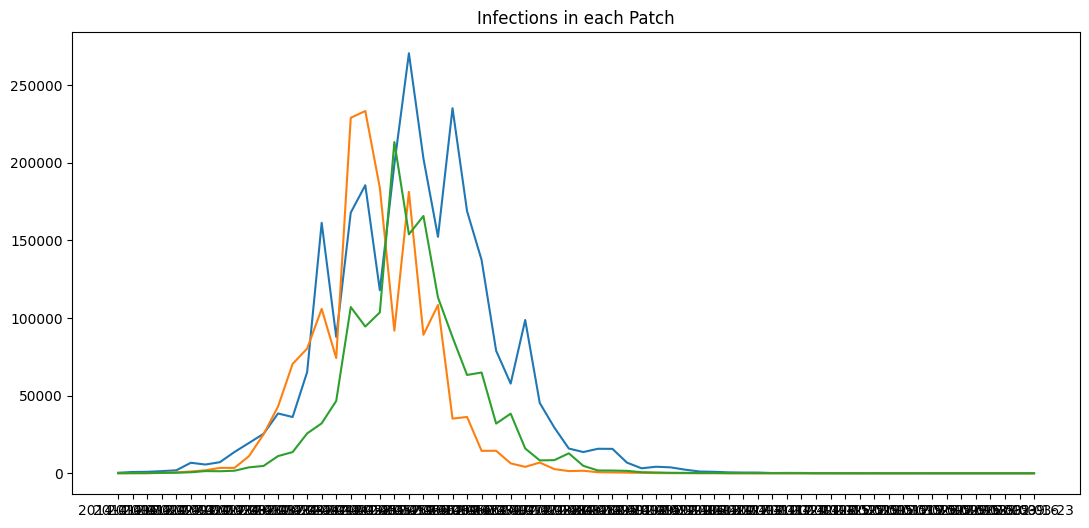

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(13, 6))
ax.plot(weekly_cases['Guinea'])
ax.plot(weekly_cases['Liberia'])
ax.plot(weekly_cases['Sierra Leone'])
ax.set_title('Infections in each Patch')
# ax[0].legend()

# ax[1].plot(weekly_cases['D_Guinea'], label='Guinea')
# ax[1].plot(weekly_cases['D_Liberia'], label='Liberia')
# ax[1].plot(weekly_cases['D_SierraLeone'], label = 'Sierra Leone')
# ax[1].set_title('Deaths in each Patch')
# ax[1].legend()

plt.show()

### Define the MCMC Simulation Function

In [92]:
## define the compartmental model
def seir_ode(z, t, params, N):
    S = z[0:3]
    E = z[3:6]
    I = z[6:9]
    R = z[9:12]
    C = z[12:15]
    # C = z[15:18]

    beta, sigma, gamma= params

    dS = -beta * S * I / N
    dE = beta * S * I / N - sigma * E
    dI = sigma * E - gamma * I
    dR = gamma * I
    # dD = alpha * I
    dC = sigma*E

    return jnp.concatenate([dS, dE, dI, dR, dC])


## define the model
def seir_model(observed_data, N_vec):

    ## Priors
    beta = jnp.array([
        numpyro.sample("beta_guinea", dist.LogNormal(jnp.log(0.3), 0.2)),
        numpyro.sample("beta_liberia", dist.LogNormal(jnp.log(0.4), 0.2)),
        numpyro.sample("beta_sierra", dist.LogNormal(jnp.log(0.35), 0.2)) 
    ])
    sigma = numpyro.sample("sigma", dist.LogNormal(jnp.log(1/8.5), 0.2))  # Mean ~ 1/8.5
    gamma = numpyro.sample("gamma", dist.LogNormal(jnp.log(1/13), 0.2))  # Mean ~ 1/13
    # alpha = numpyro.sample("alpha", dist.LogNormal(jnp.log(0.3), 0.2))  # Mean ~ 0.30
    phi = 10 #numpyro.sample("phi", dist.Exponential(5.0))

    # Initial conditions per country
    I0 = jnp.array([1000, 100, 100], dtype=jnp.float32)
    E0 = jnp.array([10, 10, 10], dtype=jnp.float32)
    R0 = jnp.array([0, 0, 0], dtype=jnp.float32)
    # D0 = jnp.array([0, 0, 0], dtype=jnp.float32)
    C0 = jnp.array([0, 0, 0], dtype=jnp.float32)
    S0 = N_vec - I0 - E0 - R0

    y0 = jnp.concatenate([S0, E0, I0, R0, C0])  # shape (15,)

    # Time vector (weekly, in days)
    T = observed_data.shape[0]
    time = jnp.arange(T) * 1.0
    param = (beta, sigma, gamma)

    # Solve ODE
    pred = numpyro.deterministic('pred', odeint(seir_ode, y0, time, param, N_vec))
    
    # print(y_hat.shape)
    pred = pred.reshape(T, 5, 3)  # (time, compartments, countries)
    # incidence = jnp.array(pred[:, 4, :])
    # Infections = []
    # for j in range(len(states)):
    #     new_infections = []
    #     for i in (range(len(states[j][:, 4]))):
    #         if i+1 == len(states[j][:, 4]):
    #             new_infections.append(0)
    #         else:
    #             new_infections.append(round(states[j][:, 4][i+1] - states[j][:, 4][i]))
    #     Infections.append(jnp.array(new_infections))

    ## Likelihood
    numpyro.sample("cases", dist.NegativeBinomial2(jnp.maximum(0.001, pred[:, 4, :]) , phi), obs=observed_data)
    # numpyro.sample("deaths", dist.NegativeBinomial2(jnp.maximum(0.001, pred[:, 4, :]) , phi), obs=observed_data2)



In [ ]:
# observed_data = jnp.array(weekly_cases[['I_Guinea', 'I_Liberia', 'I_SierraLeone']].values) # shape (T, 3)

# Set population vector (can be adjusted)
# N_vec = jnp.array([11.5e6, 4.5e6, 6.8e6], dtype=jnp.float32)
N_vec = jnp.array([4e6, 2.5e6, 2e6], dtype=jnp.float32)

nuts_kernel = NUTS(seir_model)
mcmc = MCMC(
    nuts_kernel,
    num_chains=2,
    num_warmup=500,
    num_samples=1000,
    progress_bar=True
)

mcmc.run(jax.random.PRNGKey(0), 
         observed_data=observed_cases, 
        #  observed_data2=observed_deaths,
         N_vec=N_vec)


/tmp/ipykernel_272638/4075966451.py:8: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
warmup:   7%|▋         | 110/1500 [01:59<2:11:00,  5.65s/it, 127 steps of size 1.92e-03. acc. prob=0.75]

In [11]:
mcmc.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta_guinea      0.42      0.06      0.41      0.31      0.50   2284.21      1.00
  beta_liberia      0.91      0.11      0.90      0.72      1.08   2097.07      1.00
   beta_sierra      0.71      0.08      0.70      0.57      0.84   2256.12      1.00
         gamma      0.06      0.01      0.06      0.04      0.08   2952.93      1.00
           phi      0.10      0.01      0.10      0.09      0.11   2280.61      1.00
         sigma      0.33      0.05      0.32      0.25      0.41   1807.28      1.00

Number of divergences: 0


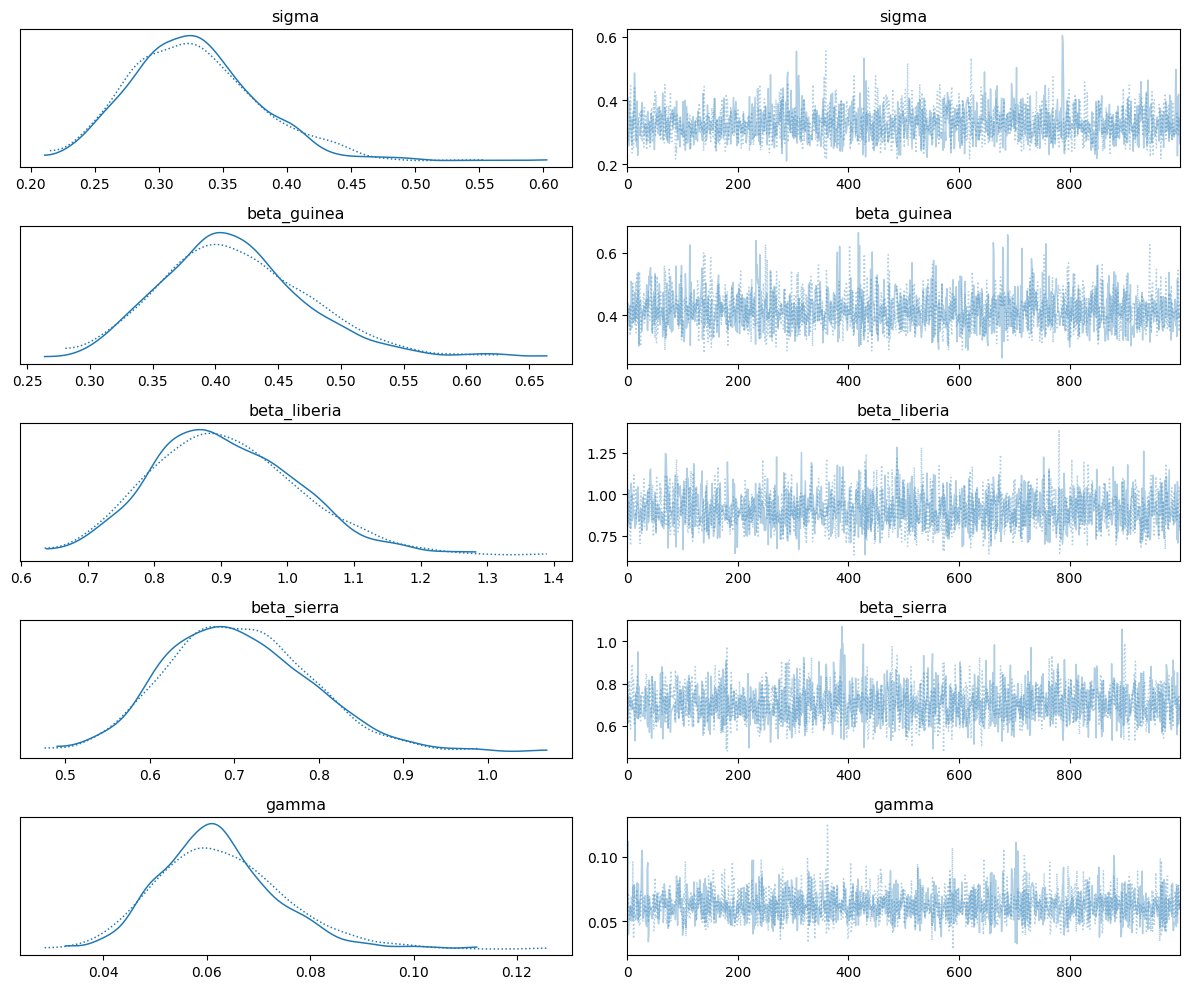

In [12]:
idata = az.from_numpyro(mcmc)
az.plot_trace(idata, var_names=['sigma', 'beta_guinea','beta_liberia', 'beta_sierra', 'gamma'], compact=True)
plt.tight_layout()

In [13]:
## get posterior samples
posterior_samp = mcmc.get_samples()
z_samp = posterior_samp['pred']
print(z_samp.shape)

(2000, 64, 15)


In [86]:
z_samp[:,:, 12:15][:,:, 0]

Array([[1.0000000e+03, 1.0560891e+03, 1.1980599e+03, ..., 3.7550968e+06,
        3.7938390e+06, 3.8263715e+06],
       [1.0000000e+03, 1.0769167e+03, 1.2658768e+03, ..., 3.6123602e+06,
        3.6486640e+06, 3.6800215e+06],
       [1.0000000e+03, 1.0617847e+03, 1.2218926e+03, ..., 3.9465605e+06,
        3.9563708e+06, 3.9642740e+06],
       ...,
       [1.0000000e+03, 1.0659795e+03, 1.2381161e+03, ..., 3.9187045e+06,
        3.9302275e+06, 3.9397780e+06],
       [1.0000000e+03, 1.0563073e+03, 1.1987339e+03, ..., 3.6062630e+06,
        3.6599570e+06, 3.7061400e+06],
       [1.0000000e+03, 1.0644413e+03, 1.2303522e+03, ..., 3.8687790e+06,
        3.8870338e+06, 3.9022758e+06]], dtype=float32)

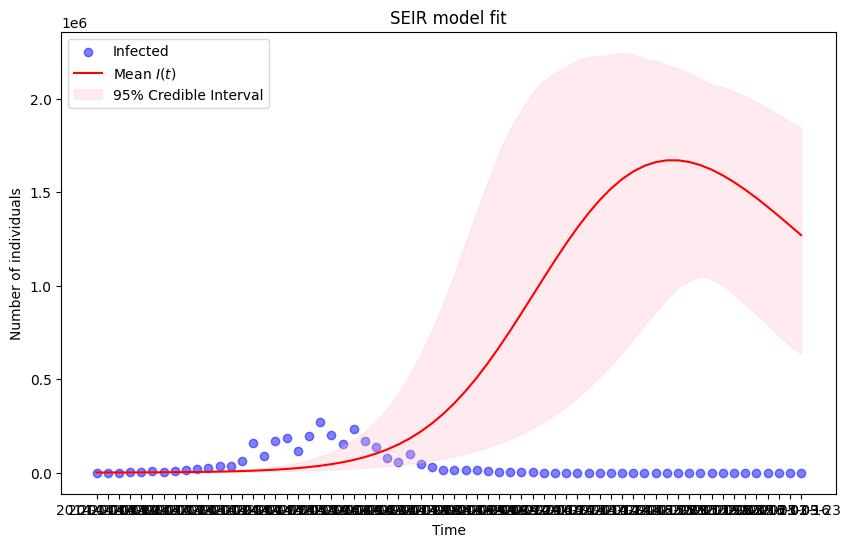

In [90]:
df2_wide = df_wide.reset_index()
# calculate median and credible intervals
lower_bound_infected = jnp.percentile(z_samp, 2.5, axis=0)[:, 6:9][:,0]
upper_bound_infected = jnp.percentile(z_samp, 97.5, axis=0)[:, 6:9][:,0]
mean_infected        = jnp.mean(z_samp, axis=0)[:, 6:9][:,0]

# plot the observed data
plt.figure(figsize=(10, 6))
plt.scatter(df2_wide['Week'], df2_wide['Guinea'], color='blue', alpha=0.5, label='Infected')

# plot median of the posterior distribution
plt.plot(df2_wide['Week'], mean_infected, color='red', label='Mean $I(t)$')

# plot uncertainty bounds
plt.fill_between(df2_wide['Week'], lower_bound_infected, upper_bound_infected, color='pink', alpha=0.3, label='95% Credible Interval')
plt.xlabel('Time')
plt.ylabel('Number of individuals')
plt.title('SEIR model fit')
plt.legend()
# plt.grid(True)
plt.show()

## Posterior Predictive check

In [23]:
from numpyro.infer import Predictive

predictive = Predictive(
    seir_model,
    posterior_samples=posterior_samp,  # from mcmc.get_samples()
    return_sites=["cases"]  # these are the observed nodes in your model
)

pp_samples = predictive(
    jax.random.PRNGKey(1),
    observed_data=observed_cases,
    # observed_data2=observed_deaths,
    N_vec=N_vec
)

In [25]:
cases_pp = pp_samples["cases"]  # shape: [n_samples, T, 3]
# deaths_pp = pp_samples["deaths"]
# cases_pp

## Plot the posterior checks

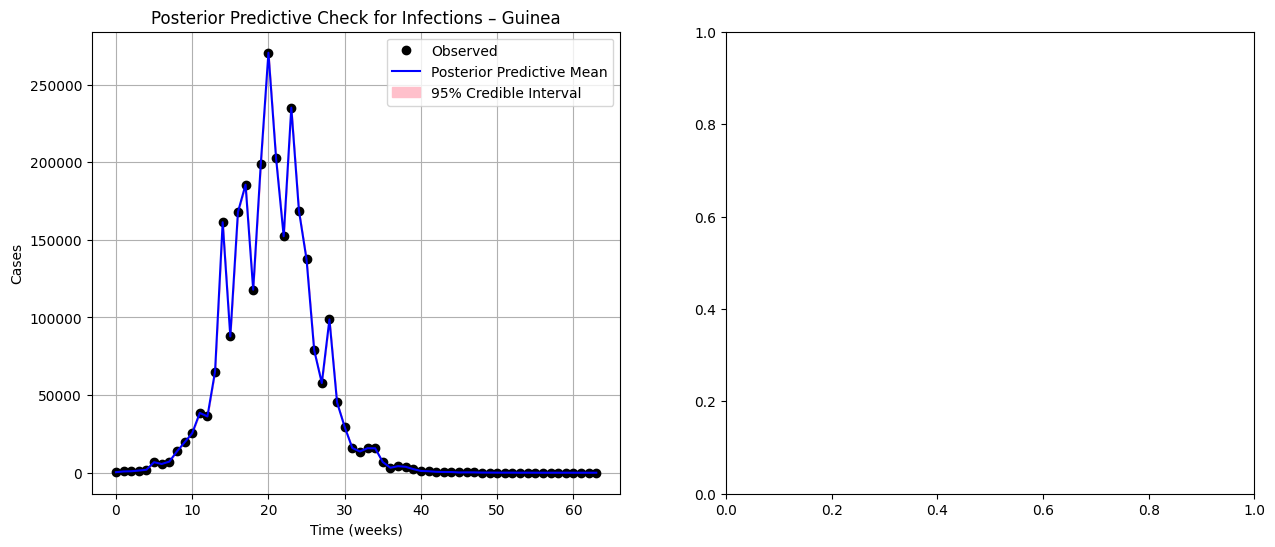

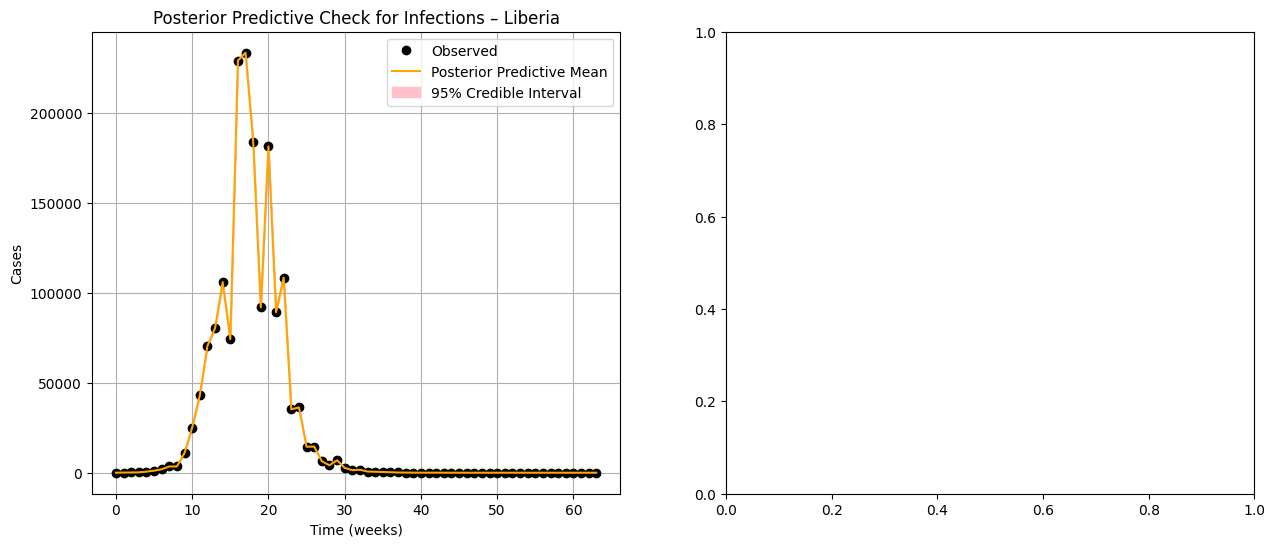

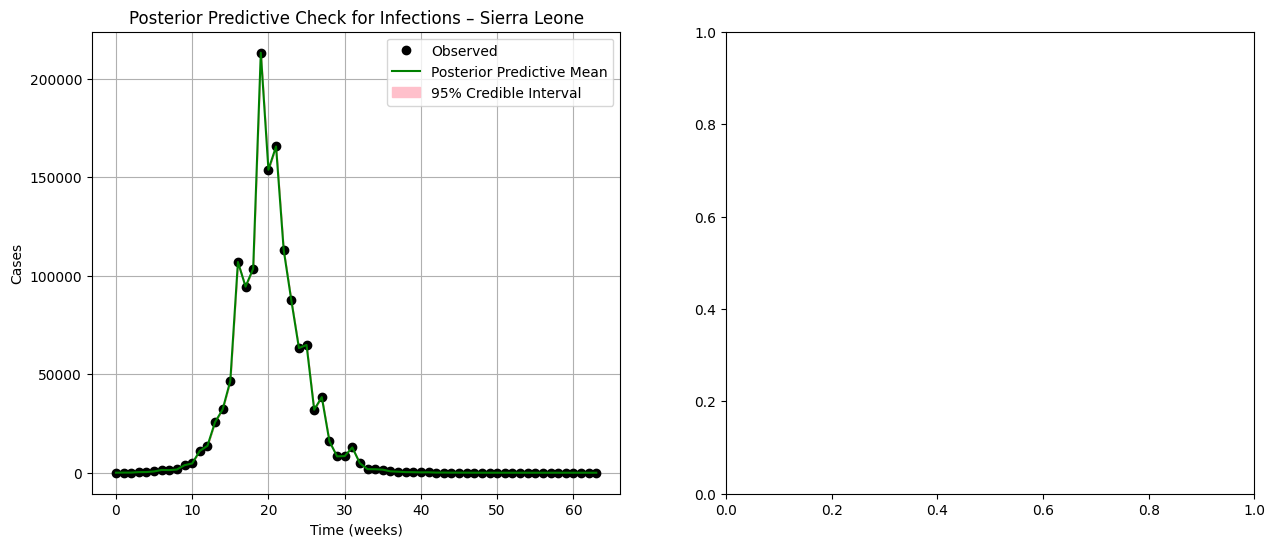

In [26]:
t = jnp.arange(observed_cases.shape[0])
countries = ['Guinea', 'Liberia', 'Sierra Leone'] # e.g., Guinea
colors = ['blue', 'orange', 'green']
for i in range(len(countries)):
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    # Compute 95% credible interval and posterior mean
    lower = jnp.percentile(cases_pp, 2.5, axis=0)[:, i]
    upper = jnp.percentile(cases_pp, 97.5, axis=0)[:, i]
    mean = jnp.mean(cases_pp, axis=0)[:, i]

    # lowerd = jnp.percentile(deaths_pp, 2.5, axis=0)[:, i]
    # upperd = jnp.percentile(deaths_pp, 97.5, axis=0)[:, i]
    # meand = jnp.mean(deaths_pp, axis=0)[:, i]

    # Plot
    ax[0].plot(t, observed_cases[:, i], 'o', label='Observed', color='black')
    ax[0].plot(t, mean, '-', label='Posterior Predictive Mean', color=colors[i])
    ax[0].fill_between(t, lower, upper, color='pink', label='95% Credible Interval')
    ax[0].set_title(f'Posterior Predictive Check for Infections – {countries[i]}')
    ax[0].set_xlabel('Time (weeks)')
    ax[0].set_ylabel('Cases')
    ax[0].legend()
    ax[0].grid(True)

    # ax[1].plot(t, observed_deaths[:, i], 'o', label='Observed', color='black')
    # ax[1].plot(t, meand, '-', label='Posterior Predictive Mean', color=colors[i])
    # ax[1].fill_between(t, lowerd, upperd, color='pink', label='95% Credible Interval')
    # ax[1].set_title(f'Posterior Predictive Check for Deaths –  {countries[i]}')
    # ax[1].set_xlabel('Time (weeks)')
    # ax[1].set_ylabel('Deaths')
    # ax[1].legend()
    # ax[1].grid(True)
    plt.show()

In [16]:
# df_beta = pd.DataFrame({
#     'Guinea': posterior_samp['beta_guinea'],
#     'Liberia': posterior_samp['beta_liberia'],
#     'SierraLeone': posterior_samp['beta_sierra']
# })

# sns.pairplot(df_beta)
# plt.suptitle("Posterior Pairplot of Beta Parameters")
# plt.show()

# Adding Coupling Effect

---
### Residents of patch i currently in patch i

---

$$
\begin{aligned}
{S'}_{ii} &= -\sum_{k=1}^n \beta_{ik} \frac{S_{ii} I_{kj}}{N_j} + \sum_{k=1}^n r_{ij} S_{ii} - g_i S_{ii} \\
{E'}_{ii} &= \sum_{k=1}^n \beta_{ik} \frac{S_{ii} I_{kj}}{N_j} - \sigma E_{ii} + \sum_{k=1}^n r_{ij} E_{ii} - g_i E_{ii} \\
{I'}_{ii} &= \sigma E_{ii} - (\gamma + \alpha) I_{ii} + \sum_{k=1}^n r_{ij} I_{ii} - g_i I_{ii} \\
{R'}_{ii} &= \gamma I_{ii} + \sum_{k=1}^n r_{ij} R_{ii} - g_i R_{ii} \\
{D'}_{ii} &= \alpha I_{ii}\\
C'_{ii} &= \sigma E_{ii}
\end{aligned}
$$

---
### Residents of patch i currently in patch j

---
$$
\begin{aligned}
S'_{ij} &= -\sum_{k=1}^n k_j \beta_{ikj}\frac{S_{ij}I_{kj}}{N_j} + g_i m_{ji}S_{ii} - r_{ij}S_{ij}\\
E'_{ij} &= \sum_{k=1}^n k_j \beta_{ikj}\frac{S_{ij}I_{kj}}{N_j} - \sigma E_{ij} + g_i m_{ji}E_{ii} - r_{ij}E_{ij}\\
I'_{ij} &= \sigma E_{ij} - (\gamma + \alpha)I_{ij} + g_im_{ji}I_{ii} - r_{ij}I_{ij}\\
R'_{ij} &= \gamma I_{ij} + g_im_{ji}R_{ii} - r_{ij}R_{ij}\\
D'_{ij} &= \alpha I_{ij}\\
C'_{ij} &= \sigma E_{ij}
\end{aligned}
$$


- $S, E, I, R, D$: Susceptible, Exposed, Infectious, Recovered, and Dead compartments
- $\beta_{ik}$: Transmission rate from patch k to individuals in patch i
- $\sigma$: Rate at which exposed individuals become infectious (1/incubation period)
- $\gamma$: Recovery rate for infectious individuals
- $\alpha$: Disease-induced death rate
- $g_i$: Rate at which individuals leave patch i
- $r_{ij}$: Rate of return from patch j to patch i
- $m_{ji}$: fraction of individuals from patch i to patch j
- $k_j$: contact rate in patch j
- $N_j$: Total population in patch j

---
$$incidence_i = \sigma × (E_{ii} + \sum_{j\neq i} E_{ij})$$

---
## Likelihoods
$$observed\_cases[t,p]∼ \text{NegativeBinomial}(ρ[p]×incidence[t,p],ϕ)$$

$$observed\_deaths[t,p]∼\text{NegativeBinomial}(ρ_d[p]×predicted\_deaths[t,p],ϕ_d)$$

Where:
- $\rho[p]$: Patch-specific reporting rate for cases
- $\rho_d[p]$: Patch-specific reporting rate for deaths
- $\phi$: Dispersion parameter for case counts
- $\phi_d$: Dispersion parameter for death counts


In [13]:
df2 = pd.read_csv('synthetic_ebola_dataset_with_death.csv')
df2 = df2[:500]

# df = pd.read_csv('synthetic_nodeath.csv')
df2['Date'] = pd.to_datetime(df2['Date'])
df2 = df2.set_index('Date')

weekly_cases = df2[['I_Guinea', 'I_Liberia', 'I_SierraLeone', 'D_Guinea', 'D_Liberia', 'D_SierraLeone']].resample('W').sum()
print(weekly_cases.shape)

observed_cases = jnp.array(weekly_cases[['I_Guinea', 'I_Liberia', 'I_SierraLeone']].values, dtype=jnp.float32) # shape (T, 3)
observed_deaths = jnp.array(weekly_cases[['D_Guinea', 'D_Liberia', 'D_SierraLeone']].values, dtype=jnp.float32) # shape (T, 3)

(63, 6)


### Define the MCMC Model with SEIRD compartments

In [ ]:
# Model equations
def SEIRD(y, t, n, params, g, m, r):
    sigma, gamma, alpha, kappa, beta = params
    S = y[:n*n].reshape(n, n)
    E = y[n*n:2*n*n].reshape(n, n)
    I = y[2*n*n:3*n*n].reshape(n, n)
    R = y[3*n*n:4*n*n].reshape(n, n)
    D = y[4*n*n:5*n*n].reshape(n, n)
    C = y[5*n*n].reshape(n,n)

    Np = jnp.sum(S + E + I + R, axis=0)  # Population in each patch (exclude D)
    dSdt = jnp.zeros((n, n))
    dEdt = jnp.zeros((n, n))
    dIdt = jnp.zeros((n, n))
    dRdt = jnp.zeros((n, n))
    dDdt = jnp.zeros((n, n))
    dCdt = jnp.zeros((n, n))

    for i in range(n):
        ## residents of Patch i who are currently in Patch j
        j = i
        foi_ii = jnp.sum(kappa[j] * beta[j] * S[i, j] * I[k, j] / Np[j] for k in range(n))

        ## calculate the change of each compartment
        dSdt[i, i] = jnp.sum(r[i, k] * S[i, k] for k in range(n)) - g[i] * S[i, i] - foi_ii
        dEdt[i, i] = jnp.sum(r[i, k] * E[i, k] for k in range(n)) - g[i] * E[i, i] + foi_ii - sigma * E[i, i]
        dIdt[i, i] = jnp.sum(r[i, k] * I[i, k] for k in range(n)) - g[i] * I[i, i] + sigma * E[i, i] - (gamma + alpha) * I[i, i]
        dRdt[i, i] = jnp.sum(r[i, k] * R[i, k] for k in range(n)) - g[i] * R[i, i] + gamma * I[i, i]
        dDdt[i, i] = alpha * I[i, i]
        dCdt[i, i] = sigma * E[i,i]

        ## residents of Patch i who are currently in Patch j
        for j in range(n):
            if j != i:
                foi = jnp.sum(kappa[j] * beta[j] * S[i, j] * I[k, j] / Np[j] for k in range(n))

                ## calculate the change of each compartment
                dSdt[i, j] = g[i] * m[j, i] * S[i, i] - r[i, j] * S[i, j] - foi
                dEdt[i, j] = g[i] * m[j, i] * E[i, i] - r[i, j] * E[i, j] + foi - sigma * E[i, j]
                dIdt[i, j] = g[i] * m[j, i] * I[i, i] - r[i, j] * I[i, j] + sigma * E[i, j] - (gamma + alpha) * I[i, j]
                dRdt[i, j] = g[i] * m[j, i] * R[i, i] - r[i, j] * R[i, j] + gamma * I[i, j]
                dDdt[i, j] = alpha * I[i, j]
                dCdt[i,j] = sigma * E[i,j]

    return jnp.concatenate([dSdt.flatten(), dEdt.flatten(), dIdt.flatten(), dRdt.flatten(), dDdt.flatten(), dCdt.flatten()])


## define the MCMC
def MCMC_model(observed_deaths, observed_cases, N_vec, I0_vec, time, param, g,m,r):
    n = N_vec.shape[0]

    ## Priors
    # beta = jnp.array([
    #     numpyro.sample("beta_guinea", dist.LogNormal(jnp.log(0.3), 0.2)),
    #     numpyro.sample("beta_liberia", dist.LogNormal(jnp.log(0.4), 0.2)),
    #     numpyro.sample("beta_sierra", dist.LogNormal(jnp.log(0.35), 0.2)) 
    # ])
    # sigma = numpyro.sample("sigma", dist.LogNormal(jnp.log(1/8.5), 0.2))  # Mean ~ 1/8.5
    # gamma = numpyro.sample("gamma", dist.LogNormal(jnp.log(1/13), 0.2))  # Mean ~ 1/13
    # alpha = numpyro.sample("alpha", dist.LogNormal(jnp.log(0.3), 0.2))  # Mean ~ 0.30
    phi = numpyro.sample("phi", dist.Exponential(5.0))
    # kappa = jnp.array([2.0, 1.5, 1.8])

    # Initial conditions per country
    I0 = jnp.array([1000, 200, 100], dtype=jnp.float32)
    E0 = jnp.array([100, 100, 10], dtype=jnp.float32)
    R0 = jnp.array([0, 0, 0], dtype=jnp.float32)
    D0 = jnp.array([0, 0, 0], dtype=jnp.float32)
    C0 = jnp.array([0, 0, 0], dtype=jnp.float32)
    S0 = N_vec - I0 - E0 - R0

    y0 = jnp.concatenate([S0, E0, I0, R0, D0, C0])  # shape (18,)

    # param = (sigma, gamma, alpha, kappa, beta)

    pred = numpyro.deterministic('pred', odeint(SEIRD, y0, time,n, param, g, m, r))

    pred = pred.reshape(len(time), 6, n, n)
    # D_obs = pred[:, 4, :, :].sum(axis=2)
    # C_obs = pred[:, 5, :, :].sum(axis=2)

    ## Likelihood
    numpyro.sample("deaths", dist.NegativeBinomial2(jnp.maximum(0.001, pred[:, 4, :, :]), phi), obs=observed_deaths)
    numpyro.sample("cases", dist.NegativeBinomial2(jnp.maximum(0.001, pred[:, 5, :, :]), phi), obs=observed_cases)

In [19]:
# Define known inputs
n = 3  # number of patches
T = observed_deaths.shape[0]
time = jnp.arange(T) * 1.0  # weekly time in days

## Define populations and initial conditions
N_vec = jnp.array([2.5e6, 1.5e6, 1.8e6])  # can be region-specific
I0_vec = jnp.array([1000., 100., 100.])  # initial infections per country

## Fixed values from literature
sigma = 1 / 8.5
gamma = 1 / 5.0
alpha = 1 / 9.3
kappa = jnp.array([2.0, 1.5, 1.8])  # Contact rates
beta = jnp.array([0.3, 0.4, 0.35]) #[0.06, 0.07, 0.08])  # Transmission probabilities

## Travel and return rate
g = jnp.array([0.001, 0.001, 0.001])  # Travel rates
m = jnp.array([[0, 0.5, 0.5], [0.5, 0, 0.5], [0.5, 0.5, 0]])  # Travel fractions
r = jnp.array([[0, 0.5, 0.5], [0.5, 0, 0.5], [0.5, 0.5, 0]])  # Return rates

param = (sigma, gamma, alpha, kappa, beta)

# Define NUTS sampler and run MCMC
nuts_kernel = NUTS(MCMC_model)
mcmc2 = MCMC(nuts_kernel, num_chains=4, 
            num_warmup=500, 
            num_samples=1000, 
            progress_bar=True)

mcmc2.run(rng_key=jax.random.PRNGKey(0), observed_deaths=observed_deaths, observed_cases=observed_cases, N_vec=N_vec, 
         I0_vec=I0_vec, time=time, 
         param = param, g = g, 
         m = m, r = r)


/tmp/ipykernel_158874/3381074628.py:26: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc2 = MCMC(nuts_kernel, num_chains=4,


IndexError: Array slice indices must have static start/stop/step to be used with NumPy indexing syntax. Found slice(None, Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace>, None). To index a statically sized array at a dynamic position, try lax.dynamic_slice/dynamic_update_slice (JAX does not support dynamically sized arrays within JIT compiled functions).

In [ ]:
mcmc.print_summary()
samples = mcmc.get_samples()